# Advanced Machine Learning - programming assignment 3

*Due: Friday January 10*

*Grading: 10 points total*

* Max Verweij - 6791409
* Teymur Rzali - 4625471

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [46]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

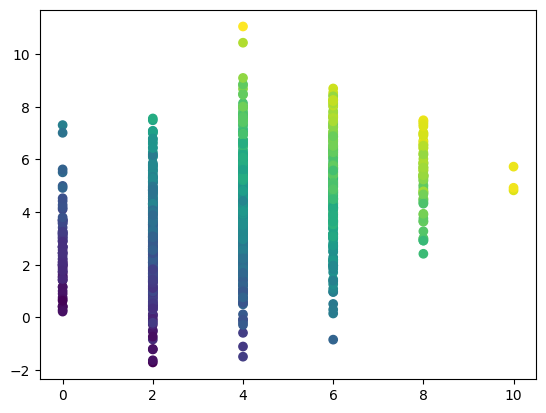

In [47]:
plt.scatter(x, y, c=z)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

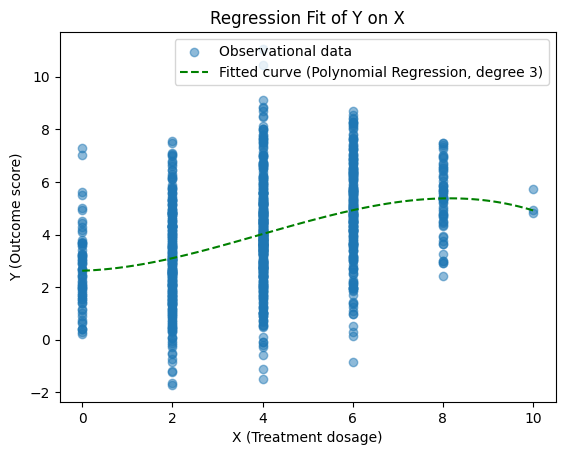

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

x_reshaped, y_reshaped = x.reshape(-1, 1), y.reshape(-1, 1)

degree = 3  # More degrees more complex the model
poly_model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
poly_model.fit(x_reshaped, y_reshaped)

x_plot = np.linspace(0, 10, 100).reshape(-1, 1)
y_plot = poly_model.predict(x_plot)

y_poly_plot = poly_model.predict(x_plot)

# Plot the original data and the polynomial regression fit
plt.scatter(x, y, alpha=0.5, label="Observational data")
plt.plot(x_plot, y_poly_plot, color="green", linestyle="--", label=f"Fitted curve (Polynomial Regression, degree {degree})")
plt.xlabel("X (Treatment dosage)")
plt.ylabel("Y (Outcome score)")
plt.title("Regression Fit of Y on X")
plt.legend()
plt.show()


Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

By analyzing the code, we can say that there are no direct causes for Z since it is generated randomly. This means genetic information is not influenced by drug dosage or recovery factors. When it comes to X, Z is the direct cause, meaning the patient's genetic information affects the dosage (X). For Y, both X and Z are the direct causes. The recovery of the patient is influenced by both their genetic profile and the drug dosage they are taking.

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [49]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X = x[i])
    z = f_Z(num_samples)  # Z is generated as before
    y = f_Y(z, x, num_samples)  # Y is generated with the fixed X and generated Z
    return (x, y, z)

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [50]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

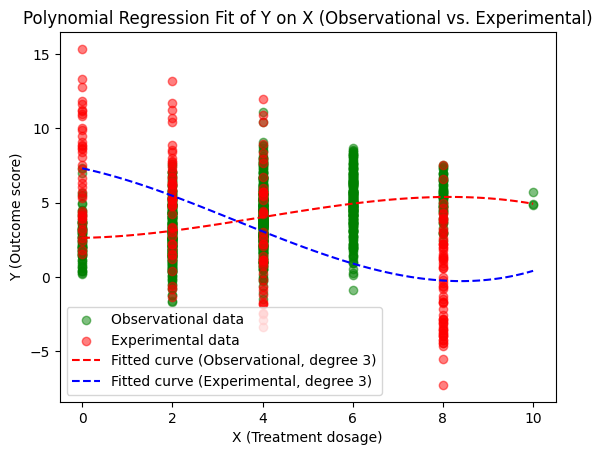

In [51]:
degree = 3

# Model for observational data
poly_model_obs = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
poly_model_obs.fit(x.reshape(-1, 1), y)  
y_obs_poly_plot = poly_model_obs.predict(np.linspace(0, 10, 100).reshape(-1, 1))

# Model for experimental data
poly_model_exp = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
poly_model_exp.fit(x_exp.reshape(-1, 1), y_exp) 
y_exp_poly_plot = poly_model_exp.predict(np.linspace(0, 10, 100).reshape(-1, 1))

plt.scatter(x, y, alpha=0.5, label="Observational data", color='green')
plt.scatter(x_exp, y_exp, alpha=0.5, label="Experimental data", color='red')
plt.plot(np.linspace(0, 10, 100), y_obs_poly_plot, color="red", linestyle="--", label=f"Fitted curve (Observational, degree {degree})")
plt.plot(np.linspace(0, 10, 100), y_exp_poly_plot, color="blue", linestyle="--", label=f"Fitted curve (Experimental, degree {degree})")
plt.xlabel("X (Treatment dosage)")
plt.ylabel("Y (Outcome score)")
plt.title("Polynomial Regression Fit of Y on X (Observational vs. Experimental)")
plt.legend()
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [52]:
from sklearn.metrics import mean_squared_error

y_exp_pred = poly_model_obs.predict(x_exp.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_exp, y_exp_pred))
print(f"RMSE on experimental data: {rmse:.4f}")

RMSE on experimental data: 5.3141


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):**

**a.** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution?

**b.** For the curve you fit on the observational data to also fit well on the experimental data, a certain conditional distribution would have had to be the same for both datasets. Which conditional distribution is that? (It may or may not appear in either product decomposition.) Explain your answer.

a. For original SCM where there is no intervention on X we can write formula like:

P(X, Y, Z) = P(Z)P(X|Z)P(Y|X, Z)

Z is independent, influences X and Y where X itself influences Y.

For modified SCM by the intervention on X:

P(X, Y, Z) = P(Z)P(X)P(Y|X, Z)

Now X is predefined, Z is randomly generated (independent), Y is still same, X and Z influence.

P(Z) and P(Y|X, Z) stays same

b. In order to curve fit well on the experimental data as well, we need conditional distribution P(Y|X, Z) to be same in both.Because this distribution describes how the outcome Y depends on both treatment and generic info which is unchanged in both scenarios. We only fix X in second option. So, having same distributions in both scenarios.

**Question 7 (1.5 points):** What (marginal or conditional) independence must hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

As X is no longer influenced by Z, Y and Z should independent given X.

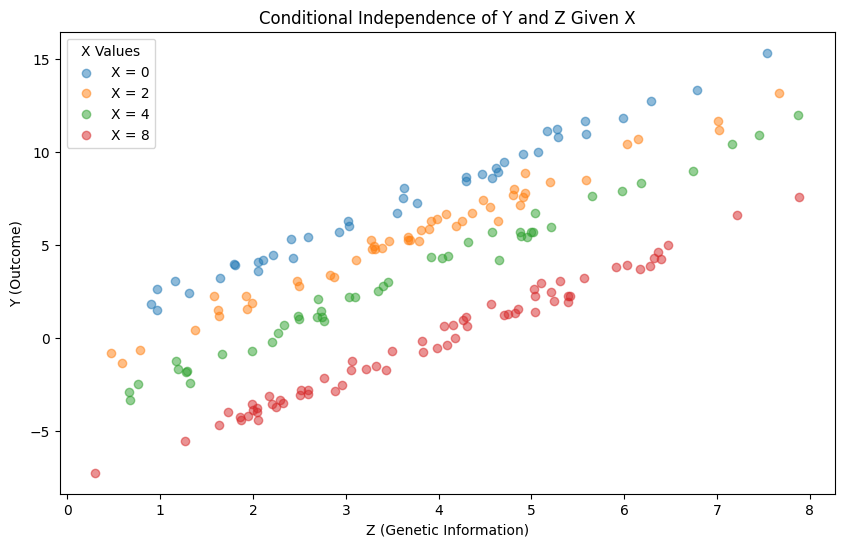

In [53]:
plt.figure(figsize=(10, 6))

for x_val in np.unique(x_exp):
    indices = x_exp == x_val
    plt.scatter(z_exp[indices], y_exp[indices], label=f'X = {x_val}', alpha=0.5)

plt.xlabel('Z (Genetic Information)')
plt.ylabel('Y (Outcome)')
plt.title('Conditional Independence of Y and Z Given X')
plt.legend(title='X Values')    
plt.show()


**Task 8 (2 points):** Now, we will use the method of inverse probability weighting (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [54]:
# Step 1: Create the logistic regression object and train 
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)
reg_logistic.fit(z.reshape(-1, 1), x)

# Step 2: Predict the probabilities of X for each Z value
predicted_probs = reg_logistic.predict_proba(z.reshape(-1, 1))

# Step 3: Get the unique values of X and map
unique_x_values = np.unique(x)
x_indices = np.searchsorted(unique_x_values, x)

# Step 4: Extract the probabilities corresponding to the true values of X for each data point 1/P(X|Z)
inverse_weights = 1 / predicted_probs[np.arange(len(x)), x_indices]

print("Inverse Probability Weights:", inverse_weights[:10])

Inverse Probability Weights: [ 2.0902127   5.00550413  1.46844359  4.01365789  1.86011513  5.0750631
  5.65116646  1.46820058 22.22007237  1.50386158]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weighting each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

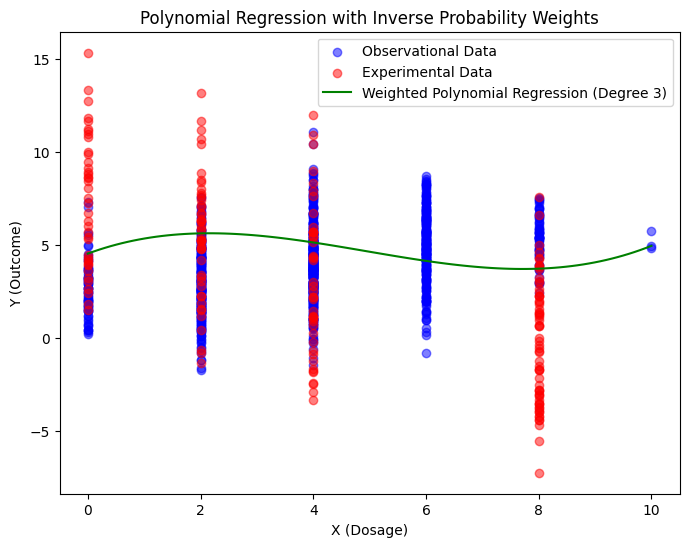

In [55]:
# Step 1: Fit a polynomial regression model to the observational data with inverse probability weights
degree = 3  # Set the polynomial degree
poly_model_weighted = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())

# Fit the model using x and y (observational data) with inverse probability weights
poly_model_weighted.fit(x.reshape(-1, 1), y, linearregression__sample_weight=inverse_weights)

# Step 2: Predict Y values using the fitted polynomial regression model for the range of X values
x_range = np.linspace(0, 10, 100).reshape(-1, 1)  # Range of X values for prediction
y_pred_weighted = poly_model_weighted.predict(x_range)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.5, label='Observational Data')
plt.scatter(x_exp, y_exp, color='red', alpha=0.5, label='Experimental Data')
plt.plot(x_range, y_pred_weighted, color='green', label=f'Weighted Polynomial Regression (Degree {degree})')
plt.xlabel('X (Dosage)')
plt.ylabel('Y (Outcome)')
plt.title('Polynomial Regression with Inverse Probability Weights')
plt.legend()
plt.show()

**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [56]:
y_pred_exp_weighted = poly_model_weighted.predict(x_exp.reshape(-1, 1))
rmse_exp_weighted = np.sqrt(mean_squared_error(y_exp, y_pred_exp_weighted))
print(f'RMSE on experimental data (with IPW and polynomial regression): {rmse_exp_weighted}')

RMSE on experimental data (with IPW and polynomial regression): 4.421988187450239


---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).